In [65]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [66]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elytk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elytk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elytk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [67]:
# Функция для удаления ненужных символов текста
def clean_text_regex(text):
    text = re.sub(r'\n', ' ', text)
    cleaned = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\s]', '', text)
    return cleaned.lower()

In [68]:
# Функция для лемматизации и удаления стоп-слов
def preprocess_text(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('russian'))
    developer_stop_words = stop_words.union({'жк', 'жилой', 'дом', 'дома', 'квартиры', 'квартира', 'квартиру', 'квартир',
                                            'комплекс', 'квм', 'этаж', 'этаже', 'этажах', 'проекта', 'строительства', 'строительство',
                                            'сдача', 'сдаче', 'площадь', 'площадью', 'квартал', 'общей', 'plus', 'также', 'тех', 'хочет', 
                                             'будут', 'наши', 'это', 'города', 'проект', 'районе', 'мин', 'км', 'продается', 'застройщика',
                                            'жилом', 'комплексе', 'добраться', 'минут', 'квартирах', 'стоят', 'построены',
                                            'большого', 'корпуса', 'строящемся', 'срок', 'продаётся', 'доме', 'застройщика', 'находится',
                                            'комнатная', 'санктпетербург', 'станет', 'район', 'вторая', 'второй', 'очереди', 'санктпетербурга',
                                            'iiкв', 'ivкв', 'октябрьская', 'пулковский', 'рсти', 'московский', 'заречье', 'колпинском',
                                             'руднева', 'указана', 'остров', 'живописном', 'югтаун', 'состоящий', 'академическая',
                                            'цветной', 'комплекса',
                                            'пулково', 'трёхкомнатных', 'домов', 'трёх', 'установлены', 'выполнена', 'всё', 
                                             'жилое', 'воедино', 'наших', 'четырех', 'корпус', 'сдачи', 'новый', 'расположен'})
    tokens = [word for word in tokens if word not in developer_stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = [token for token in tokens if len(token) > 2]
    return ' '.join(tokens)

In [69]:
# Считываем файл и удаляем NaN в важных столбцах
data = pd.read_csv('buildings.csv')
data.dropna(subset=['min_metro'], inplace=True)
data.dropna(subset=['total_area'], inplace=True)
data.dropna(subset=['rooms'], inplace=True)
# Создаем столбец с "относительным" этажом
data['is_city'] = data['is_city'].astype(int)
data['floor_perc'] = round(data['floor_current'] * 100 / data['floor_total'])
data['description'] = data['description'].fillna('')

In [70]:
# Применяем функции для предобработки текста
data['review_cleaned'] = data['description'].apply(lambda x: preprocess_text(clean_text_regex(x)))

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Векторизуем текст
tfidf_vectorizer = TfidfVectorizer(
    max_features=500
)

X_tfidf = tfidf_vectorizer.fit_transform(data['review_cleaned'])

In [72]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Стандартизация числовых признаков
numeric_features = ['floor_perc', 'min_metro', 'total_area', 'is_city']
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(data[numeric_features])

# Кодирование категориальных признаков
categorical_features = ['rooms', 'hc_class']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_encoded = encoder.fit_transform(data[categorical_features])

In [73]:
import numpy as np
from scipy.sparse import hstack

# Объединение всех признаков
all_features = hstack([
    X_tfidf, 
    numeric_scaled, 
    categorical_encoded 
])

In [74]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Уменьшаем размерность для лучшего выделения кластеров
reducer = PCA(n_components=2, random_state=42)
X_reduced = reducer.fit_transform(all_features)

Кластеров: 2, Silhouette Score: 0.498
Кластеров: 3, Silhouette Score: 0.523
Кластеров: 4, Silhouette Score: 0.452
Кластеров: 5, Silhouette Score: 0.441
Кластеров: 6, Silhouette Score: 0.434
Кластеров: 7, Silhouette Score: 0.452
Кластеров: 8, Silhouette Score: 0.456
Кластеров: 9, Silhouette Score: 0.444
Кластеров: 10, Silhouette Score: 0.447


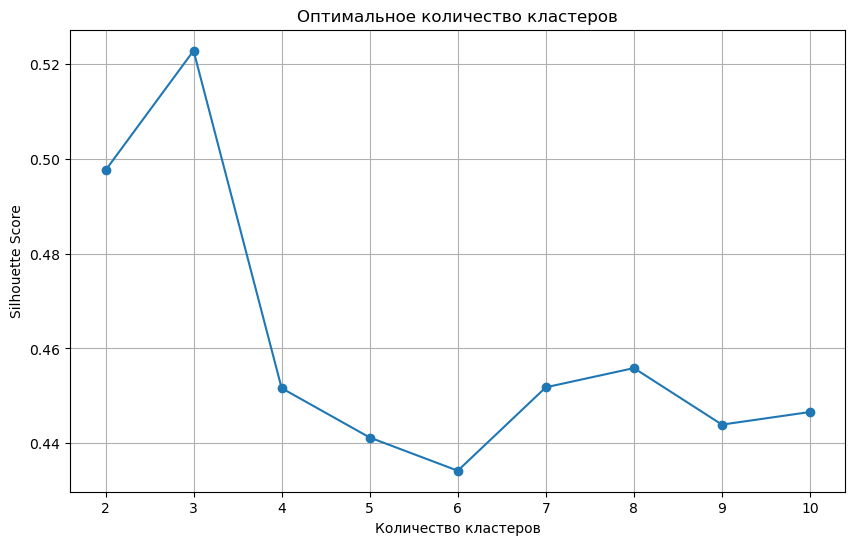

In [75]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []

# Производим подбор количества кластеров с помощью подсчета метрики
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_reduced)
    score = silhouette_score(X_reduced, cluster_labels)
    silhouette_scores.append(score)
    print(f"Кластеров: {n_clusters}, Silhouette Score: {score:.3f}")
    
# Визуализация
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')
plt.title('Оптимальное количество кластеров')
plt.show()
    
optimal_n = np.argmax(silhouette_scores) + 2

# Обучаем K-Means с оптимальным количеством кластеров
kmeans = KMeans(n_clusters=optimal_n, random_state=42, n_init=10)
data['cluster'] = kmeans.fit_predict(X_reduced)

In [76]:
# Функция для извлечения топа слов
def extract_key_themes(df, n_keywords=10):
    from sklearn.feature_extraction.text import CountVectorizer
    
    themes_by_cluster = {}
    
    for cluster_id in df['cluster'].unique():
            
        cluster_texts = df[df['cluster'] == cluster_id]['review_cleaned'].tolist()
        
        # Используем CountVectorizer для частотного анализа
        cv = CountVectorizer(max_features=100, ngram_range=(1, 3))
        cv_matrix = cv.fit_transform(cluster_texts)
        
        # Получаем частоты слов
        word_counts = cv_matrix.sum(axis=0)
        words_freq = [(word, word_counts[0, idx]) 
                     for word, idx in cv.vocabulary_.items()]
        
        # Сортируем по частоте
        words_freq.sort(key=lambda x: x[1], reverse=True)
        
        # Берем топ слов
        top_keywords = [word for word, freq in words_freq[:n_keywords]]
        themes_by_cluster[cluster_id] = top_keywords
    
    return themes_by_cluster

# Извлекаем ключевые темы
themes = extract_key_themes(data, n_keywords=10)
print("\nКлючевые темы по кластерам:")
for cluster_id, keywords in themes.items():
    print(f"Кластер {cluster_id}: {', '.join(keywords)}")


Ключевые темы по кластерам:
Кластер 2: метро, отделкой, авто, территории, станции, площадки, окна, станции метро, отдыха, общая
Кластер 0: авто, петербурга, метро, город, отдыха, отделкой, система, станции, жизни, территория
Кластер 1: жизни, отдыха, школа, мест, территории, детские, площадки, отделкой, поликлиника, детских


In [77]:
data['cluster'].value_counts()

cluster
1    603
2    581
0    188
Name: count, dtype: int64

Text(0.5, 1.0, 'Визуализация кластеров товаров')

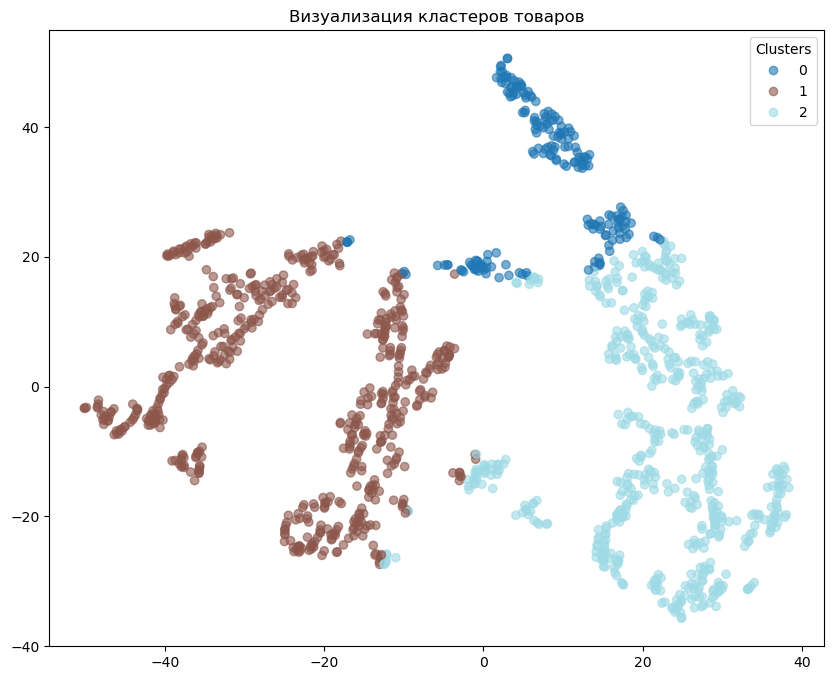

In [78]:
# Анализ характеристик кластеров
cluster_stats = data.groupby('cluster').agg({
    'total_area': ['mean'],
    'min_metro': ['mean'],
    'rooms': lambda x: x.mode()[0] if not x.mode().empty else None,
    'floor_perc': ['mean'],
    'hc_class': lambda x: x.mode()[0] if not x.mode().empty else None,
})

# Визуализация кластеров
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(X_reduced)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                      c=data['cluster'], cmap='tab20', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('Визуализация кластеров товаров')

In [79]:
cluster_stats

,total_area,min_metro,rooms,floor_perc,hc_class
,mean,mean,<lambda>,mean,<lambda>
cluster,,,,,
0,93.858564,7.888298,3.0,68.239362,Премиум
1,47.368806,16.072968,1.0,40.782753,Комфорт
2,36.782823,6.683305,1.0,34.624785,Комфорт
